# Field Sampling


The particle trajectories allow us to study fields like temperature, plastic concentration or chlorophyll from a Lagrangian perspective.

In this tutorial we will go through how particles can sample `Fields`, using temperature as an example. Along the way we will get to know the parcels class `Variable` (see [here](https://parcels.readthedocs.io/en/latest/reference/particles.html#parcels.particle.Variable) for the documentation) and some of its methods. This tutorial covers several applications of a sampling setup:

- [**Basic along trajectory sampling**](#Basic-sampling)
- [**Sampling velocity fields**](#Sampling-velocity-fields)
- [**Sampling initial conditions**](#Sampling-initial-values)


## Basic sampling

We import both the packages that we need to set up the simulation, as well as the parcels package.


In [1]:
# Modules needed for the Parcels simulation
from datetime import timedelta

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# To open and look at the temperature data
import xarray as xr

import parcels

/var/folders/fd/p7j_05zx409dzmtfjjjnjgfh0000gn/T/ipykernel_14343/2773850306.py:11: UserWarning: This is an alpha version of Parcels v4. The API is not stable and may change without deprecation warnings.
  import parcels


Suppose we want to study the environmental temperature for plankton drifting in the Agulhas current. We have a CopernicusMarine dataset with surface ocean velocities and the corresponding potential temperature stored in netcdf files in the [parcels example dataset repository](https://github.com/OceanParcels/parcels-data). Loading in the FieldSet, parcels detects U and V because they have CF standard names and tells us that they are assumed as the velocity fields to be used in the simulation.


In [137]:
# Load the CopernicusMarine data in the Agulhas region from the example_datasets
example_dataset_folder = parcels.download_example_dataset(
    "CopernicusMarine_data_for_Argo_tutorial"
)

ds = xr.open_mfdataset(f"{example_dataset_folder}/*.nc", combine="by_coords")
ds.load()  # load the dataset into memory

fieldset = parcels.FieldSet.from_copernicusmarine(ds)

INFO: cf_xarray found variable 'uo' with CF standard name 'eastward_sea_water_velocity' in dataset, renamed it to 'U' for Parcels simulation.
INFO: cf_xarray found variable 'vo' with CF standard name 'northward_sea_water_velocity' in dataset, renamed it to 'V' for Parcels simulation.


 Ten particles are initialized at the surface in the center of our domain, at the initial time step.

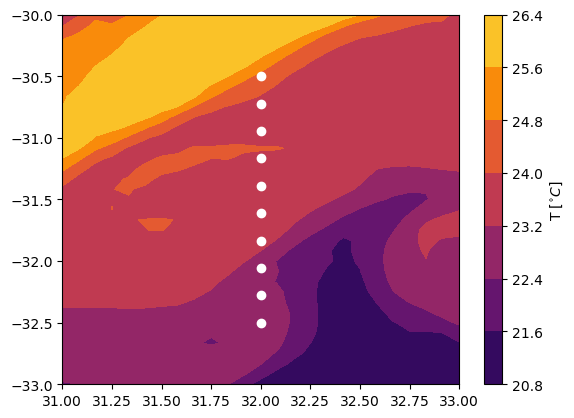

In [139]:
# Particle locations and initial time
npart = 10  # number of particles to be released
lon = 32 * np.ones(npart)
lat = np.linspace(-32.5, -30.5, npart, dtype=np.float32)
time = (
    np.repeat(ds.time.values[0], npart)
)  # release all particles at the same time
# time = (
#     ds.time.values[0]+np.arange(0, npart) * np.timedelta64(2,'h')
# )  # release each particle two hours later
depth = np.repeat(ds.depth.values[0], npart)

# Plot temperature field and initial particle locations
plt.figure()
ax = plt.axes()
T_contour = ax.contourf(
    ds.longitude.values, ds.latitude.values, ds.thetao.values[0, 0], cmap=plt.cm.inferno, vmin=20, vmax=27
)
ax.scatter(lon, lat, c="w")
plt.colorbar(T_contour, label=r"T [$^{\circ} C$]")
plt.show()

To sample the temperature field, we need to create a new class of particles where temperature is a `Variable`. We then also need a new Kernel `SampleT` that interpolates the temperature field at the particle location and stores that in `particle.temperature`.


In [140]:
SampleParticle = parcels.Particle.add_variable(parcels.Variable("temperature",dtype=np.float32, initial=np.nan))

def SampleT(particles, fieldset):
    particles.temperature = fieldset.thetao[particles.time, particles.depth, particles.lat, particles.lon]

We can then sample and Advect by combining the `SampleT` and `AdvectionRK4` kernels in a list. Note that the order does not matter.


In [141]:
pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=SampleParticle, lon=lon, lat=lat, time=time, depth=depth
)

output_file = parcels.ParticleFile("SampleTemp.zarr", outputdt=timedelta(hours=1))

pset.execute(
    [parcels.kernels.AdvectionRK4, SampleT],
    runtime=timedelta(hours=30),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in /Users/Gebruiker/Documents/GitHub/parcels/docs/examples/SampleTemp.zarr
Integration time: 2024-01-02T05:00:00.000000000: 100%|██████████| 108000.0/108000.0 [00:01<00:00, 63759.06it/s]


The particle dataset now contains the particle trajectories and the corresponding environmental temperature


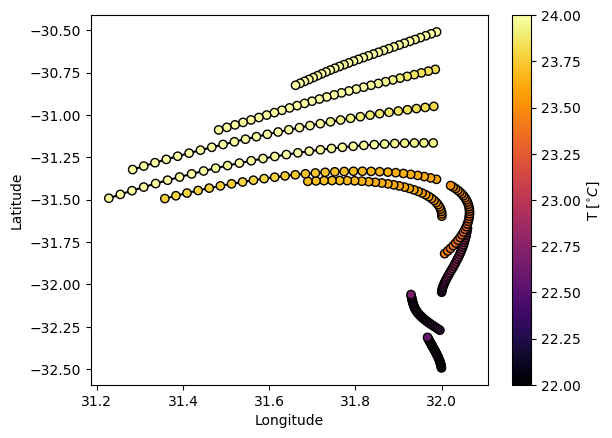

In [ ]:
Particle_data = xr.open_zarr("SampleTemp.zarr", decode_times=False)

plt.figure()
ax = plt.axes()
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
# ax.set_ylim(-33, -30)
# ax.set_xlim(31, 33)
ax.plot(Particle_data.lon.transpose(), Particle_data.lat.transpose(), c="k", zorder=1)
T_scatter = ax.scatter(
    Particle_data.lon,
    Particle_data.lat,
    c=Particle_data.temperature,
    cmap=plt.cm.inferno,
    norm=mpl.colors.Normalize(vmin=22.0, vmax=24.0),
    edgecolor="k",
    zorder=2,
)
plt.colorbar(T_scatter, label=r"T [$^{\circ} C$]")
plt.show()

## Sampling velocity fields


Because Parcels works also for generalised curvilinear grids, you need to tread somewhat carefully when wanting to sample the velocity fields `U` and `V`. In fact, Parcels will throw a warning when directly calling a sampling of either of these fields:


In [144]:
def SampleVel_wrong(particles, fieldset):
    u = fieldset.U[particles]


pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=parcels.Particle, lon=lon, lat=lat, time=time, depth=depth
)

pset.execute(SampleVel_wrong, runtime=timedelta(hours=30),
    dt=timedelta(minutes=5),)

Integration time: 2024-01-01T00:00:00.000000000:   0%|          | 0/108000.0 [00:00<?, ?it/s]

/Users/Gebruiker/Documents/GitHub/parcels/parcels/_core/field.py:233: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


Integration time: 2024-01-01T00:00:00.000000000: 100%|██████████| 108000.0/108000.0 [00:00<00:00, 501877.76it/s]


Instead, you should use the code `u, v = fieldset.UV[...]`. With this code, the sampling is consistent with the actual velocity fields used in the advection Kernels. The difference is that on a curvilinear grid, `fieldset.U[..]` returns the velocity in the `i`-direction (the columns on the grid), while `fieldset.UV[...]` returns the velocities in the longitude and latitude direction. Furthermore, only `fieldset.UV[...]` sampling can correctly deal with boundary conditions such as `freeslip` and `partialslip` ([documentation_unstuck_Agrid](https://docs.oceanparcels.org/en/latest/examples/documentation_unstuck_Agrid.html#3.-Slip-boundary-conditions))


In [145]:
def SampleVel_correct(particles, fieldset):
    u, v = fieldset.UV[particles]


pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=parcels.Particle, lon=lon, lat=lat, time=time, depth=depth
)

pset.execute(SampleVel_correct, runtime=timedelta(hours=30), dt=timedelta(minutes=5))

Integration time: 2024-01-01T00:00:00.000000000: 100%|██████████| 108000.0/108000.0 [00:00<00:00, 356388.56it/s]


To sample U and V as part of a larger script the following code could be used:

In [146]:
SampleParticle = parcels.Particle.add_variable(
    [
        parcels.Variable("U", dtype=np.float32, initial=np.nan),
        parcels.Variable("V", dtype=np.float32, initial=np.nan),
    ]
)


def SampleVel_correct(particles, fieldset):
    # attention: samples particle velocity in units of the mesh (deg/s or m/s)
    particles.U, particles.V = fieldset.UV[particles]

<div class="alert alert-info">

Note that the Kernels above return the value of `U` and `V` in the units of the grid. That means that for a spherical grid, the velocities are in **degrees/s**. To convert these to **m/s**, see the [UnitConversion tutorial](https://docs.oceanparcels.org/en/latest/examples/tutorial_unitconverters.html).
</div>

## Sampling initial values


In some simulations only the particles initial value within the field is of interest: the variable does not need to be known along the entire trajectory. To reduce computing we can specify the `to_write` argument to the temperature `Variable`. This argument can have three values: `True`, `False` or `'once'`. It determines whether to write the `Variable` to the output file. If we want to know only the initial value, we can enter `'once'` and only the first value will be written to the output file.


In [147]:
SampleParticleOnce = parcels.Particle.add_variable(
    parcels.Variable("temperature", initial=np.nan, to_write="once")
)

pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=SampleParticleOnce, lon=lon, lat=lat, time=time, depth=depth
)

In [148]:
output_file = parcels.ParticleFile("WriteOnce.zarr", outputdt=timedelta(hours=1))

pset.execute(
    [parcels.kernels.AdvectionRK4, SampleT],
    runtime=timedelta(hours=30),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in /Users/Gebruiker/Documents/GitHub/parcels/docs/examples/WriteOnce.zarr
Integration time: 2024-01-02T05:00:00.000000000: 100%|██████████| 108000.0/108000.0 [00:01<00:00, 68626.37it/s]


Since all the particles are released at the same x-position and the temperature field is invariant in the y-direction, all particles have an initial temperature of 0.4$^\circ$C


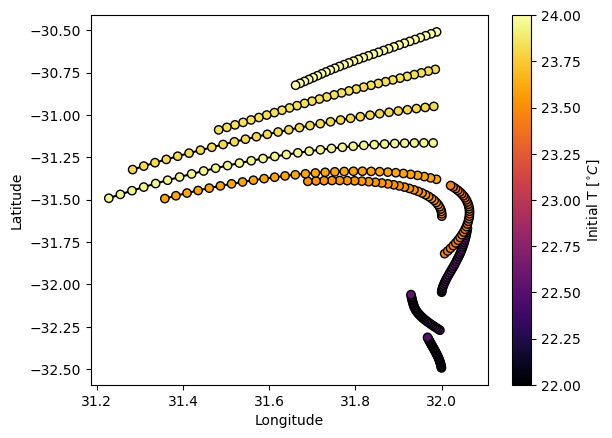

In [149]:
Particle_data_once = xr.open_zarr("WriteOnce.zarr", decode_times=False)

plt.figure()
ax = plt.axes()
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
ax.plot(Particle_data_once.lon.transpose(), Particle_data_once.lat.transpose(), c="k", zorder=1)
T_scatter = ax.scatter(
    Particle_data_once.lon,
    Particle_data_once.lat,
    c=np.tile(Particle_data_once.temperature, (Particle_data_once.lon.shape[1], 1)).T,
    cmap=plt.cm.inferno,
    norm=mpl.colors.Normalize(vmin=22.0, vmax=24.0),
    edgecolor="k",
    zorder=2,
)
plt.colorbar(T_scatter, label=r"Initial T [$^{\circ} C$]")
plt.show()

We can compare the output where only the initial value is written to output, with the original simulation, where the temperature at each outputdt is written:

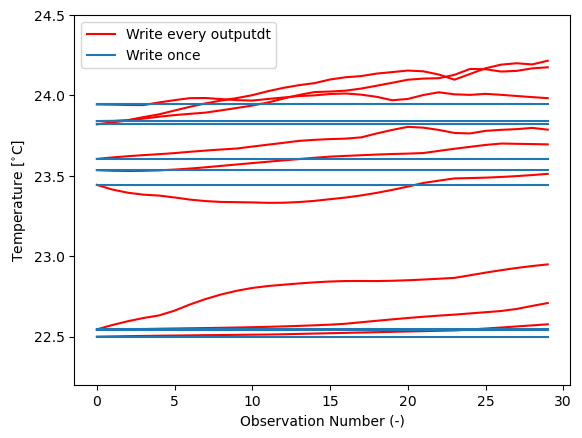

In [153]:
plt.figure()
ax = plt.axes()
ax.set_ylabel("Temperature [$^{\\circ}$C]")
ax.set_xlabel("Observation Number (-)")
ax.set_ylim(22.2, 24.5)
# ax.set_xlim(31, 33)
l1=ax.plot(Particle_data.obs, Particle_data.temperature.T, color='red')
l2=ax.plot(Particle_data_once.obs, np.tile(Particle_data_once.temperature, (Particle_data_once.lon.shape[1], 1)), color='tab:blue')
ax.legend([l1[0],l2[0]], ['Write every outputdt','Write once'])
plt.show()